<a href="https://colab.research.google.com/github/jjungmini/pv_ongoing/blob/main/final/h2o_%EC%A0%84%EC%B2%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install h2o
!pip install mxnet
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.2
    Uninstalling graphviz-0.20.2:
      Successfully uninstalled graphviz-0.20.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.7 MB/s eta 0:00:00


In [2]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns

In [3]:
# 데이터 로딩
df = pd.read_excel('pv_data_ongoing.xlsx', sheet_name=3)

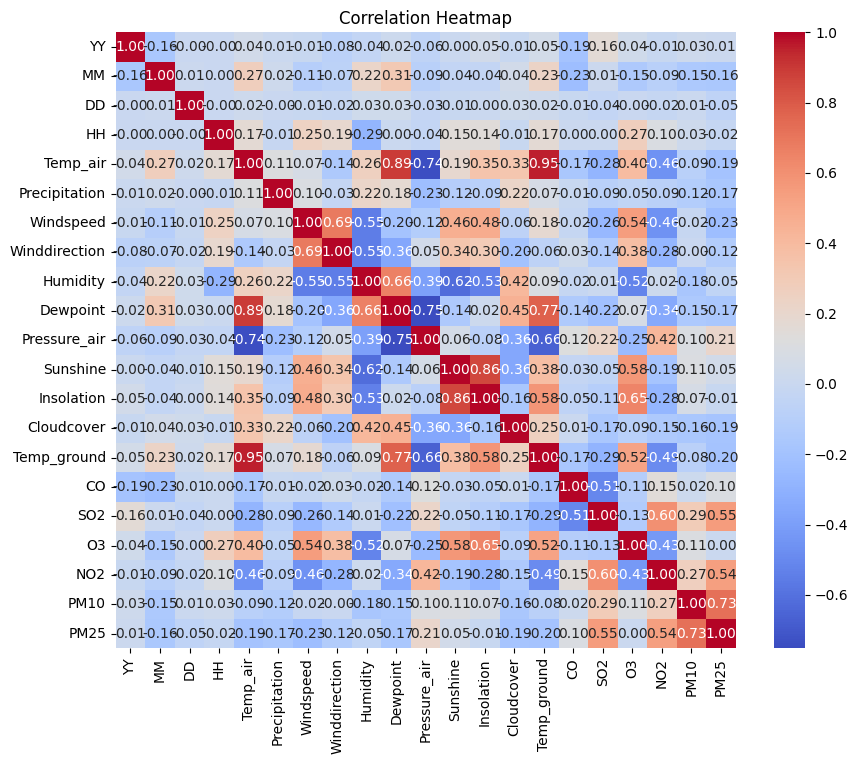

In [4]:
# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외

correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-08-01']
test = df[(df['Date'] >= '2023-08-01') & (df['Date'] < '2023-09-01')]

# AutoML 학습을 위한 데이터셋 설정

In [5]:
# 선택된 특성만 남김('Precipitation', 'Dewpoint' 제거)
selected_features_train = train.drop(columns=['Date', 'solarpower', 'Precipitation', 'Dewpoint']).columns
train = train[['Date', 'solarpower'] + selected_features_train.tolist()]
train.columns

Index(['Date', 'solarpower', 'YY', 'MM', 'DD', 'HH', 'Temp_air', 'Windspeed',
       'Winddirection', 'Humidity', 'Pressure_air', 'Sunshine', 'Insolation',
       'Cloudcover', 'Temp_ground', 'CO', 'SO2', 'O3', 'NO2', 'PM10', 'PM25'],
      dtype='object')

In [6]:
# H2O 라이브러리 초기화
h2o.init()

# H2O 데이터프레임으로 변환
h2o_train = h2o.H2OFrame(train.drop('Date', axis=1))

# Date 열을 제외한 특성과 타겟 변수를 정의
x = h2o_train.columns
x.remove('solarpower')

y = 'solarpower'

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2a_ub9a7
  JVM stdout: /tmp/tmp2a_ub9a7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2a_ub9a7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_ezzcxn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
# AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
aml = H2OAutoML(
     max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
    # max_models=20,             # 생성할 최대 모델 수
    stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
    stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
    stopping_rounds=3,         # 조기 종료를 위한 반복 횟수
    nfolds=5,                  # 교차 검증(fold)의 개수
    seed=42,                   # 랜덤 시드
    # exclude_algos = ["StackedEnsemble"],

   #include_algos=['Deeplearning'], #'DRF', 'XGBoost'],  # 사용할 알고리즘들의 리스트
    keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
    keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
    keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
    sort_metric='RMSE',        # 성능 측정 기준
    export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

aml.train(x=x, y=y, training_frame=h2o_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),7/59
# GBM base models (used / total),5/22
# XGBoost base models (used / total),2/26
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/8
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


# Automl 학습결과 확인

In [8]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# 모든 모델의 성능 순위를 변수로 저장
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    exec(f"model_rank_{rank} = h2o.get_model('{model_id}')")

# 모든 모델의 성능 순위 출력
print("\n<< 모든 모델의 성능 순위 >>")
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    print(f"Model: {model_id}, Rank: {rank}")

model_id                                                     rmse          mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_4_AutoML_1_20240326_73812     0.0233817  0.000546702  0.0124297  0.0179079               0.000546702
StackedEnsemble_AllModels_3_AutoML_1_20240326_73812     0.0233883  0.000547014  0.0124314  0.0179127               0.000547014
StackedEnsemble_BestOfFamily_4_AutoML_1_20240326_73812  0.0237044  0.000561899  0.0127044  0.0181454               0.000561899
StackedEnsemble_AllModels_2_AutoML_1_20240326_73812     0.023878   0.000570158  0.0129004  0.018286                0.000570158
StackedEnsemble_AllModels_1_AutoML_1_20240326_73812     0.0238854  0.000570514  0.0128839  0.0182859               0.000570514
StackedEnsemble_BestOfFamily_2_AutoML_1_20240326_73812  0.0242537  0.000588241  0.0130633  0.0185571               0.000588241
StackedEnsemble_BestOfFamily_3_AutoML_1_20240326_73812  0.0242786  0.000589452  0.0131919  0.0185972           

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"



<< 모든 모델의 성능 순위 >>
Model: StackedEnsemble_AllModels_4_AutoML_1_20240326_73812, Rank: 1
Model: StackedEnsemble_AllModels_3_AutoML_1_20240326_73812, Rank: 2
Model: StackedEnsemble_BestOfFamily_4_AutoML_1_20240326_73812, Rank: 3
Model: StackedEnsemble_AllModels_2_AutoML_1_20240326_73812, Rank: 4
Model: StackedEnsemble_AllModels_1_AutoML_1_20240326_73812, Rank: 5
Model: StackedEnsemble_BestOfFamily_2_AutoML_1_20240326_73812, Rank: 6
Model: StackedEnsemble_BestOfFamily_3_AutoML_1_20240326_73812, Rank: 7
Model: GBM_grid_1_AutoML_1_20240326_73812_model_10, Rank: 8
Model: GBM_4_AutoML_1_20240326_73812, Rank: 9
Model: GBM_grid_1_AutoML_1_20240326_73812_model_5, Rank: 10
Model: StackedEnsemble_BestOfFamily_1_AutoML_1_20240326_73812, Rank: 11
Model: GBM_grid_1_AutoML_1_20240326_73812_model_2, Rank: 12
Model: GBM_grid_1_AutoML_1_20240326_73812_model_9, Rank: 13
Model: GBM_1_AutoML_1_20240326_73812, Rank: 14
Model: GBM_2_AutoML_1_20240326_73812, Rank: 15
Model: GBM_3_AutoML_1_20240326_73812, Rank:

In [9]:
# 순위별로 모델에 대한 세부 정보 출력
# n등의 모델을 출력하려면 : print(model_rank_n)
print(model_rank_1)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_4_AutoML_1_20240326_73812


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       7/59
# GBM base models (used / total)           5/22
# XGBoost base models (used / total)       2/26
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  0/8
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00013808913933277723
RMSE: 0.011751133533952256
MAE: 0.006666747342080152
RMSLE: 0.0092

In [10]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# Excel 파일 생성
writer = pd.ExcelWriter('train_result_전체.xlsx', engine='xlsxwriter')

# 모든 모델의 파라미터 정보를 저장하는 새로운 열을 추가합니다.
all_parameters = []
for index, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)
    model_params = model.params
    all_parameters.append(model_params)

leaderboard_df['Parameters'] = all_parameters

# DataFrame을 첫 번째 시트로 저장합니다.
leaderboard_df.to_excel(writer, sheet_name='Leaderboard', index=True)



# 엑셀 파일 저장
writer.save()

model_id                                                     rmse          mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_4_AutoML_1_20240326_73812     0.0233817  0.000546702  0.0124297  0.0179079               0.000546702
StackedEnsemble_AllModels_3_AutoML_1_20240326_73812     0.0233883  0.000547014  0.0124314  0.0179127               0.000547014
StackedEnsemble_BestOfFamily_4_AutoML_1_20240326_73812  0.0237044  0.000561899  0.0127044  0.0181454               0.000561899
StackedEnsemble_AllModels_2_AutoML_1_20240326_73812     0.023878   0.000570158  0.0129004  0.018286                0.000570158
StackedEnsemble_AllModels_1_AutoML_1_20240326_73812     0.0238854  0.000570514  0.0128839  0.0182859               0.000570514
StackedEnsemble_BestOfFamily_2_AutoML_1_20240326_73812  0.0242537  0.000588241  0.0130633  0.0185571               0.000588241
StackedEnsemble_BestOfFamily_3_AutoML_1_20240326_73812  0.0242786  0.000589452  0.0131919  0.0185972           

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-10-a6873246fc5c>:27: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# 모델 학습 결과 시각화 용

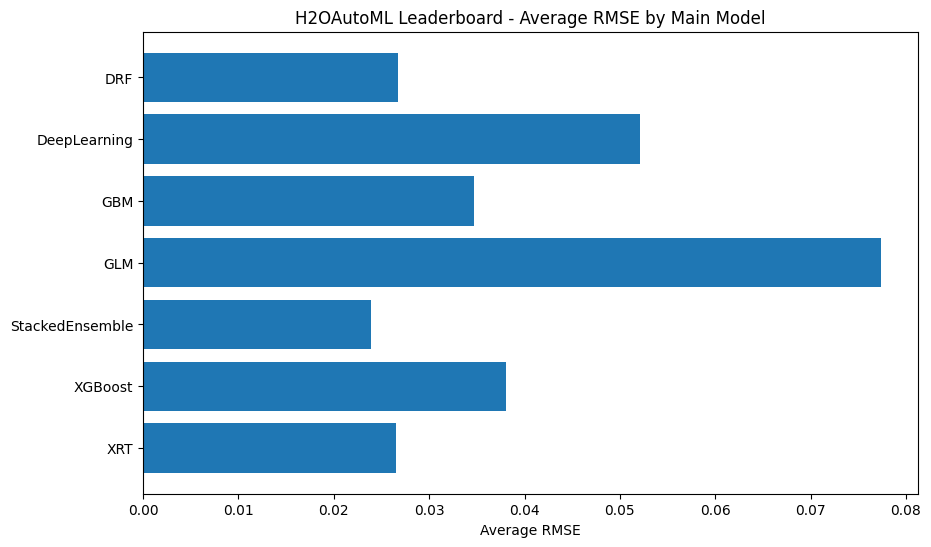

In [11]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 평균값 계산
group_means = grouped_leaderboard['rmse'].mean()

# 그룹 평균값을 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(group_means.index, group_means.values)
plt.xlabel('Average RMSE')
plt.title('H2OAutoML Leaderboard - Average RMSE by Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()

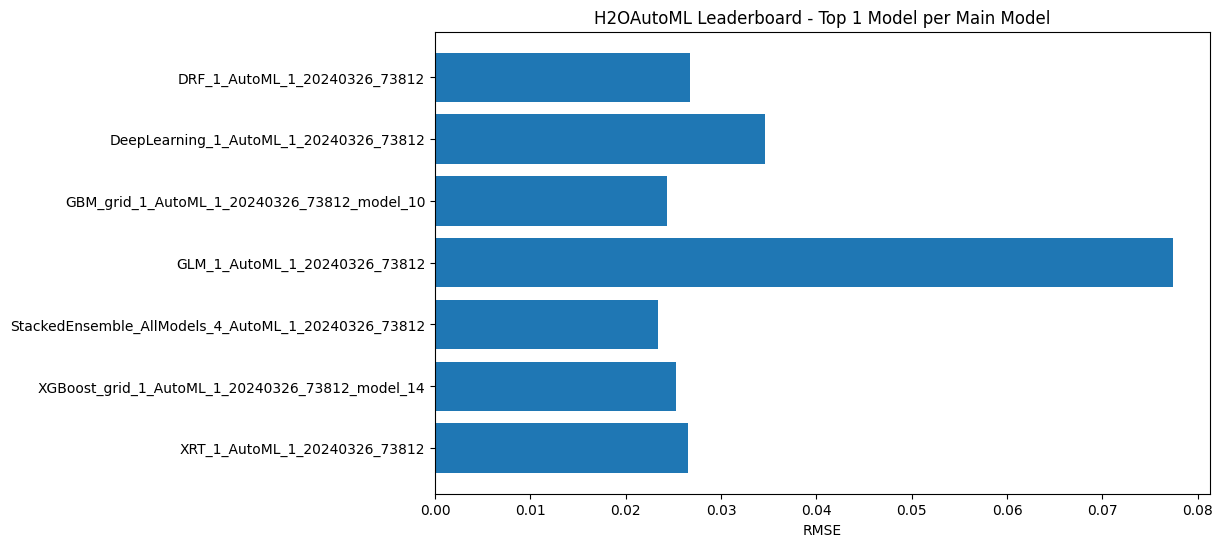

In [12]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 1위 모델 선택 (가장 낮은 RMSE 값을 가진 모델)
top_1_models = grouped_leaderboard.apply(lambda group: group.nsmallest(1, 'rmse'))

# 메인 모델별 1위 모델의 RMSE를 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(top_1_models['model_id'], top_1_models['rmse'])
plt.xlabel('RMSE')
plt.title('H2OAutoML Leaderboard - Top 1 Model per Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()

# best 모델 출력하고, 예측을 위한 df 변환

In [13]:
# 가장 성능이 좋은 모델 선택
best_model = aml.leader

# 선택된 특성 출력
print("Best model is: ", best_model)

Best model is:  Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_4_AutoML_1_20240326_73812


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       7/59
# GBM base models (used / total)           5/22
# XGBoost base models (used / total)       2/26
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  0/8
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00013808913933277723
RMSE: 0.011751133533952256
MAE: 0.0066667473420801

In [14]:
# 모델 저장
model_path = h2o.save_model(model=best_model, path="/content/", force=True)
print("모델 저장 경로:", model_path)

모델 저장 경로: /content/StackedEnsemble_AllModels_4_AutoML_1_20240326_73812


In [15]:
# Stacked Ensemble 모델의 구조 확인
# Stacked Ensemble 모델의 경우, `model_id`를 통해 세부 모델들을 확인할 수 있습니다.
print("Stacked Ensemble Model 구조:")
best_model.model_performance()

Stacked Ensemble Model 구조:


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00013808913933277723
RMSE: 0.011751133533952256
MAE: 0.006666747342080152
RMSLE: 0.009223960141286626
Mean Residual Deviance: 0.00013808913933277723
R^2: 0.996510192463716
Null degrees of freedom: 10060
Residual degrees of freedom: 10053
Null deviance: 398.10665880160803
Residual deviance: 1.3893148308270717
AIC: -60848.374556054834

In [16]:
# 구성 모델의 세부 정보 확인
Metalearner = best_model.metalearner()
print("Metalearner 세부 정보:")
Metalearner.summary()

Metalearner 세부 정보:


,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 7.929E-5 )",59,7,1,levelone_training_StackedEnsemble_AllModels_4_AutoML_1_20240326_73812


In [17]:
Metalearner

,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 7.929E-5 )",59,7,1,levelone_training_StackedEnsemble_AllModels_4_AutoML_1_20240326_73812
,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
aic,-29325.5350000,360.3079,-29082.9510000,-28972.8710000,-29902.2810000,-29375.1680000,-29294.41
loglikelihood,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mae,0.0124291,0.0001023,0.0125278,0.0122639,0.0124967,0.0124172,0.0124397
mean_residual_deviance,0.0005467,0.0000138,0.0005693,0.0005449,0.0005320,0.0005413,0.0005462
mse,0.0005467,0.0000138,0.0005693,0.0005449,0.0005320,0.0005413,0.0005462
null_deviance,252.8526,9.381261,251.3618,239.18832,262.87656,250.44554,260.39075
r2,0.9864092,0.0005879,0.9857716,0.9858763,0.9871181,0.9864365,0.9868434
residual_deviance,3.4324121,0.0822410,3.5759676,3.3778598,3.3859248,3.3969183,3.4253893


In [18]:
# 메타러너의 변수 중요도 조회
variable_importances = Metalearner.varimp(True)

# Pandas DataFrame으로 결과를 포맷하여 출력하기
import pandas as pd
vi_df = pd.DataFrame(variable_importances, columns=["variable", "relative_importance", "scaled_importance", "percentage"])
print(vi_df)

                                             variable  relative_importance  \
0         GBM_grid_1_AutoML_1_20240326_73812_model_10             0.071003   
1                       GBM_4_AutoML_1_20240326_73812             0.061474   
2          GBM_grid_1_AutoML_1_20240326_73812_model_5             0.023313   
3     XGBoost_grid_1_AutoML_1_20240326_73812_model_14             0.015844   
4          GBM_grid_1_AutoML_1_20240326_73812_model_9             0.013733   
5      XGBoost_grid_1_AutoML_1_20240326_73812_model_6             0.007289   
6          GBM_grid_1_AutoML_1_20240326_73812_model_2             0.006744   
7                       GBM_1_AutoML_1_20240326_73812             0.000000   
8                       GBM_2_AutoML_1_20240326_73812             0.000000   
9                       GBM_3_AutoML_1_20240326_73812             0.000000   
10         GBM_grid_1_AutoML_1_20240326_73812_model_8             0.000000   
11        GBM_grid_1_AutoML_1_20240326_73812_model_12           

In [19]:
variable_importances = Metalearner.varimp(use_pandas=True)

# 퍼센테이지가 0 초과인 베이스 모델만 필터링
filtered_vi = variable_importances[variable_importances['percentage'] > 0]

# 결과 출력
print(filtered_vi)

                                          variable  relative_importance  \
0      GBM_grid_1_AutoML_1_20240326_73812_model_10             0.071003   
1                    GBM_4_AutoML_1_20240326_73812             0.061474   
2       GBM_grid_1_AutoML_1_20240326_73812_model_5             0.023313   
3  XGBoost_grid_1_AutoML_1_20240326_73812_model_14             0.015844   
4       GBM_grid_1_AutoML_1_20240326_73812_model_9             0.013733   
5   XGBoost_grid_1_AutoML_1_20240326_73812_model_6             0.007289   
6       GBM_grid_1_AutoML_1_20240326_73812_model_2             0.006744   

   scaled_importance  percentage  
0           1.000000    0.356083  
1           0.865799    0.308297  
2           0.328336    0.116915  
3           0.223147    0.079459  
4           0.193415    0.068872  
5           0.102651    0.036552  
6           0.094984    0.033822  


In [20]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 선택된 특성만 남김('Precipitation', 'Dewpoint' 제거)
selected_features_test = test.drop(columns=['Date', 'solarpower', 'Precipitation', 'Dewpoint']).columns
test = test[['Date', 'solarpower'] + selected_features_test.tolist()]

# 테스트 데이터를 H2O 데이터프레임으로 변환
h2o_test = h2o.H2OFrame(test.drop('Date', axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# 원하는 rank의 모델 사용하여 test data 예측 수행

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 115.01557891678593
평균 절대 오차 (MAE): 6.45012625995533
결정 계수 (R2): 0.9862024203887021
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 10.724531640905626


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-20-85139e42cb40>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


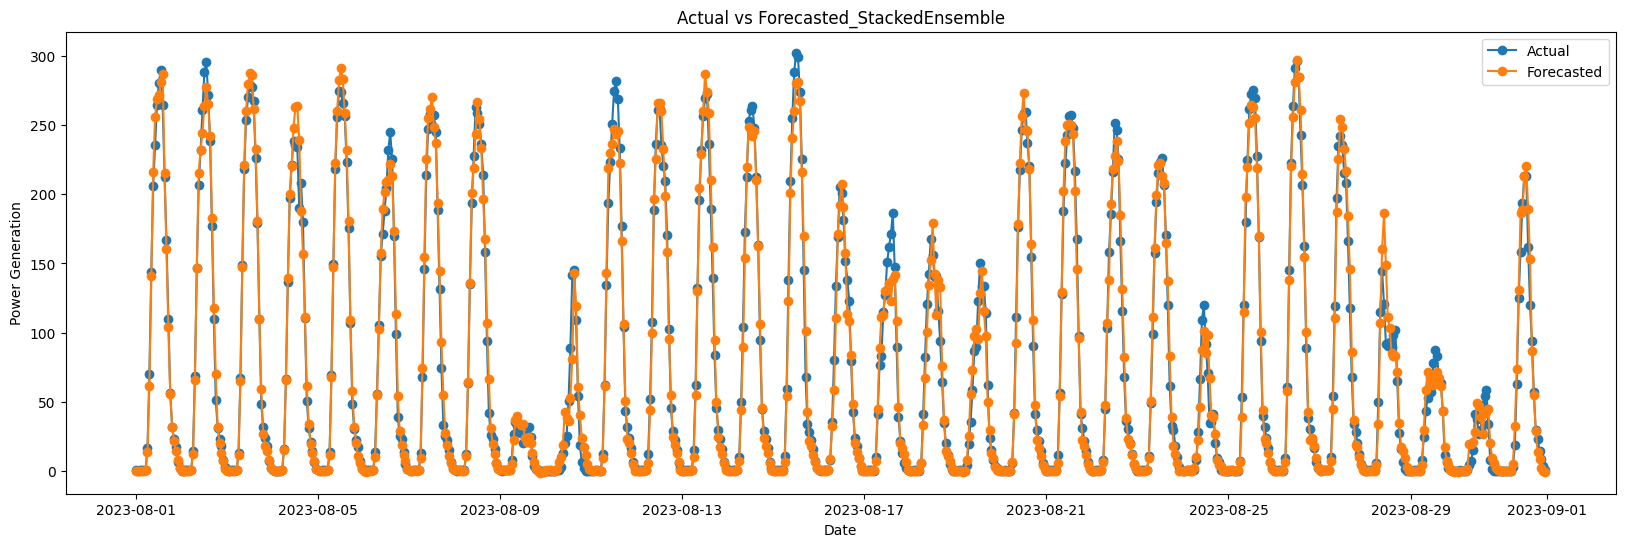

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 125.76836665191031
평균 절대 오차 (MAE): 6.93576264432148
결정 계수 (R2): 0.9849124869186796
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 11.214649644634928


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-20-85139e42cb40>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


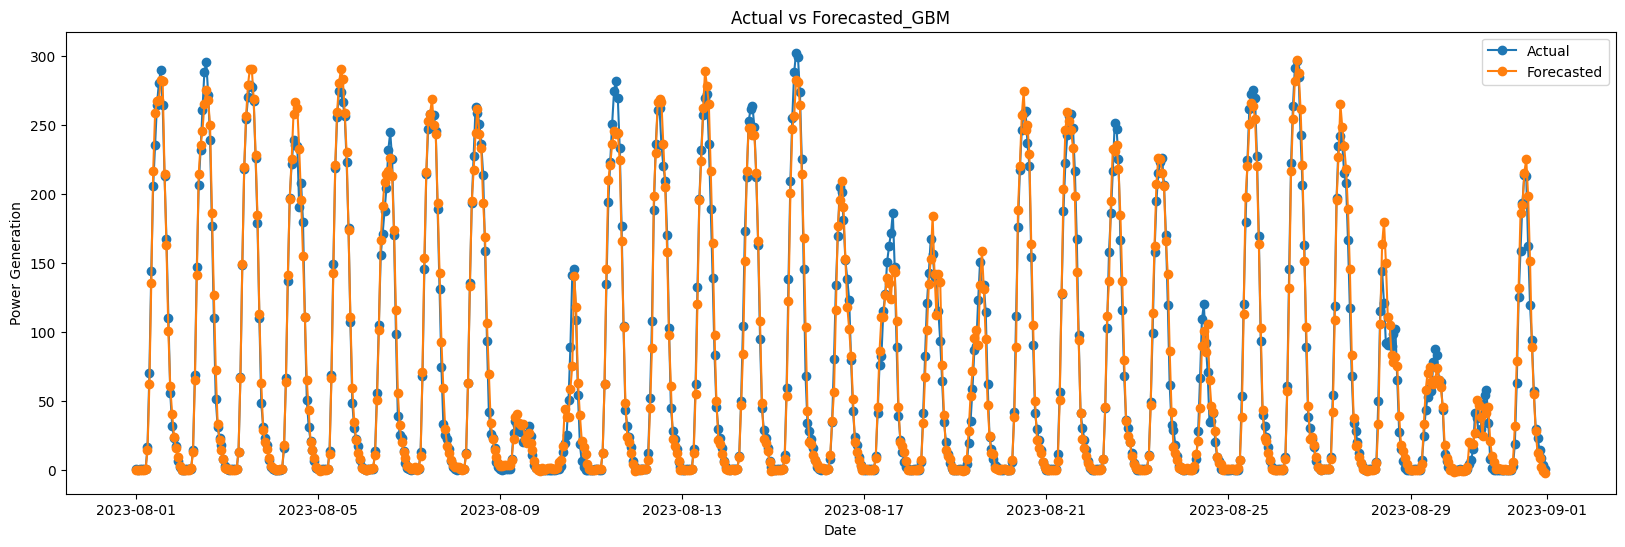

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 164.0953598066252
평균 절대 오차 (MAE): 7.528360778580817
결정 계수 (R2): 0.980314677262855
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 12.809971108734992


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
<ipython-input-20-85139e42cb40>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


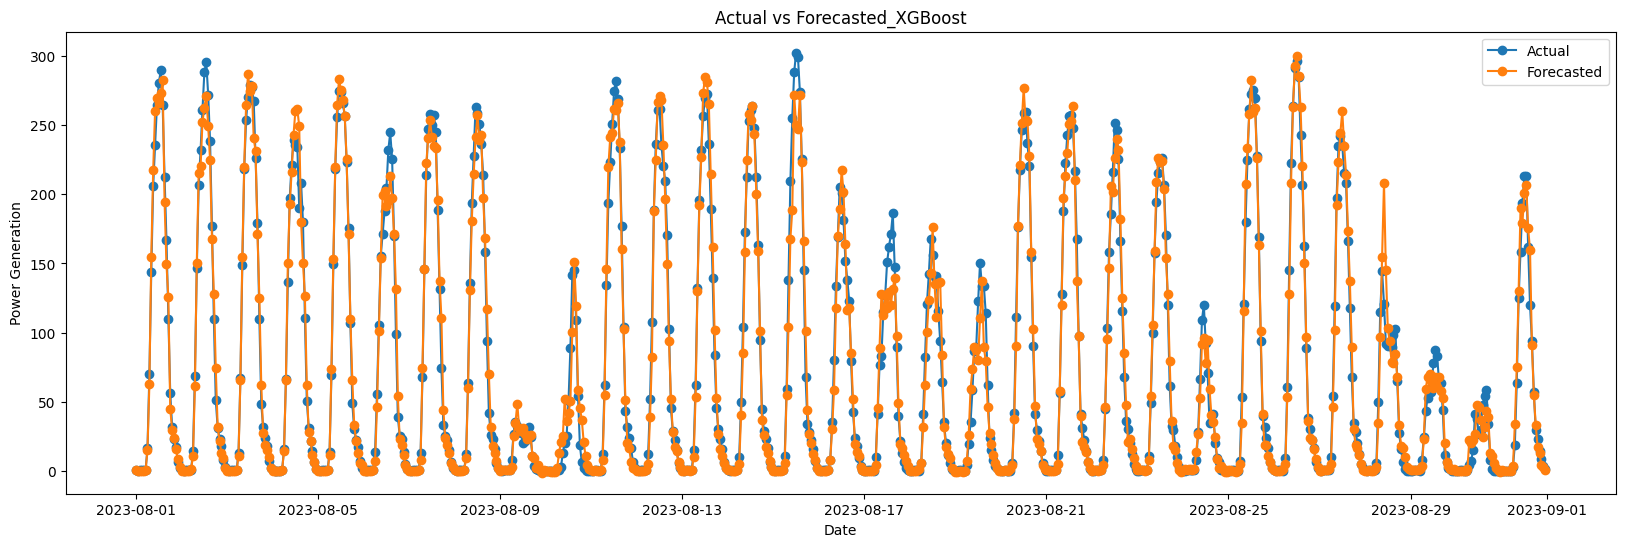

In [21]:
all_predictions = pd.DataFrame()
all_evaluations = pd.DataFrame()
for i in [model_rank_1, model_rank_8, model_rank_17]:
  # 원하는 rank의 모델을 사용하여 예측 수행
  predictions = i.predict(h2o_test) #model_rank_n
  predictions = predictions.as_data_frame()

  # 예측된 값을 원래 스케일로 역변환
  predictions = target_scaler.inverse_transform(predictions)

  # 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
  actual_values = test['solarpower'].values.reshape(-1, 1)
  actual_values = target_scaler.inverse_transform(actual_values)

  # 각 rank의 값의 모델명을 파일명으로 사용
  name_index = i.model_id.find("_")
  model_name = i.model_id[:name_index]

  # 평가 지표 계산
  mse = mean_squared_error(actual_values, predictions)
  mae = mean_absolute_error(actual_values, predictions)
  r2 = r2_score(actual_values, predictions)
  mape = mean_absolute_percentage_error(actual_values, predictions)
  rmse = np.sqrt(mse)

  # 평가 지표 출력
  print("평균 제곱 오차 (MSE):", mse)
  print("평균 절대 오차 (MAE):", mae)
  print("결정 계수 (R2):", r2)
  print("평균 절대 백분율 오차 (MAPE):", mape)
  print("평균 제곱근 오차 (RMSE):", rmse)

  # 실제 값과 예측값 시각화
  plt.figure(figsize=(20, 6))
  plt.plot(test['Date'], actual_values, label='Actual', marker='o')
  plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
  plt.xlabel('Date')
  plt.ylabel('Power Generation')
  plt.title(f'Actual vs Forecasted_{model_name}')
  plt.legend()
  plt.show()

  # 모든 평가지표를 데이터프레임으로 저장
  all_evaluations[model_name] = [mse, mae, r2, mape, rmse]

  # 모든 예측값 저장
  all_predictions[model_name] = predictions[:,0]

# 엑셀 파일로 저장
all_evaluations.to_excel('평가_전체.xlsx', index=False)

# 예측값 파일 저장
file_name = '예측값_전체.xlsx'
all_predictions.to_excel(file_name, index=False)